# Learning goals
After today's lesson you should be able to:
- Understand the use cases for different type of spatial weights

This week's lesson is a simplied version of:  
- The [Chapter 4 in Geographic Data Science textbook](https://geographicdata.science/book/notebooks/04_spatial_weights.html)

In [1]:
# import contextily as cx
import geopandas as gpd
import rioxarray

import seaborn as sns
sns.set_context(context='paper')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from pysal.lib import cg as geometry
from pysal.lib import weights

## warnings is a module that allows you to filter warnings
import warnings
## we are going to ignore all warnings (so they won't print)
warnings.filterwarnings("ignore")

c:\Users\desai\miniforge3\envs\crp4680\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Spatial Weights


"Spatial weights" are one way to represent graphs in geographic data science and spatial statistics. They are widely used constructs that represent geographic relationships between the observational units in a spatially referenced dataset. Implicitly, spatial weights connect objects in a geographic table to one another using the spatial relationships between them. **By expressing the notion of geographical proximity or connectedness, spatial weights are the main mechanism through which the spatial relationships in geographical data is brought to bear in the subsequent analysis.**

## Introduction

Spatial weights often express our knowledge about spatial relationships. 
For example, proximity and adjacency are common spatial questions: *What neighborhoods are you surrounded by? How many gas stations are within 5 miles of my stalled car?*
These are spatial questions that target specific information about the spatial configuration of a specific target ("a neighborhood," "my stalled car") and geographically connected relevant sites ("adjacent neighborhoods", "nearby gas stations"). For us to use this information in statistical analysis, it's often necessary to compute these relationships between all pairs of observations. This means that, for many applications in geographic data science, we are building a *topology*---a mathematical structure that expresses the connectivity between observations---that we can use to examine the data. Spatial weights matrices express this topology, letting us embed all of our observations in space together, rather than asking and answering single questions about features nearby a unit. 

</figure>
<img src="https://www.researchgate.net/publication/327776659/figure/fig1/AS:672948855791617@1537454918147/A-typical-spatial-weights-matrix-Note-that-A-and-E-do-not-share-a-side-thus-their.png" alt="drawing" width="600" style="display: block; margin: 0 auto"/>
<figcaption>From Bi, Y., Xie, J., Sha, Z., Wang, M., Fu, Y., & Chen, W. (2018, August). Modeling spatiotemporal heterogeneity of customer preferences in engineering design. In International Design Engineering Technical Conferences and Computers and Information in Engineering Conference (Vol. 51753, p. V02AT03A050). American Society of Mechanical Engineers.</figcaption>
</figure>




Since they provide a way to represent these spatial relationships, spatial weights are widely used throughout spatial and geographic data science.
In this chapter, we first consider different approaches to construct spatial weights, distinguishing between those based on **contiguity/adjacency relations** from weights obtained from **distance based relationships**. We illustrate all of these concepts through the spatial weights class in `pysal`, which provides a rich set of methods and characteristics for spatial weights and it is stored under the `weights` submodule:

In [2]:
from pysal.lib import weights

Everyone check: Which version of `pysal.lib` do you have? 

In [3]:
import pysal
pysal.lib.__version__

'4.2.1'

Throughout the chapter, we discuss common file formats used to store spatial weights of different types, and we include visual discussion of spatial weights, making these sometimes abstract constructs more intuitive.

## Contiguity Weights

A contiguous pair of spatial objects are those who share a common border. At first
glance this seems straightforward. However, in practice this turns out to be
more complicated. The first complication is that there are different ways that objects can "share a common border." Let's start with the example of a three-by-three grid. We can create it as a geo-table from scratch:

In [4]:
# Get points in a grid
l = np.arange(3)
xs, ys = np.meshgrid(l, l)
# Set up store
polys = []
# Generate polygons
for x, y in zip(xs.flatten(), ys.flatten()):
    poly = Polygon([(x, y), (x + 1, y), (x + 1, y + 1), (x, y + 1)])
    polys.append(poly)
# Convert to GeoSeries
polys = gpd.GeoSeries(polys)
gdf = gpd.GeoDataFrame(
    {
        "geometry": polys,
        "id": ["P-%s" % str(i).zfill(2) for i in range(len(polys))],
    }
)

which results in the grid shown in the following figure. 

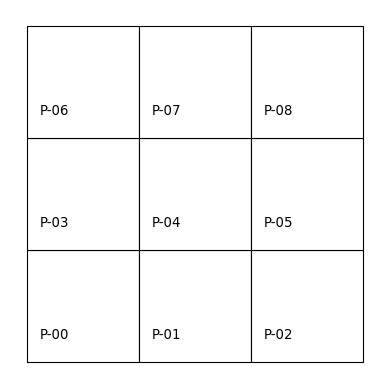

In [5]:
# Plot grid geotable
ax = gdf.plot(facecolor="w", edgecolor="k")

# Loop over each cell and add the text
for x, y, t in zip(
    [p.centroid.x - 0.25 for p in polys],
    [p.centroid.y - 0.25 for p in polys],
    [i for i in gdf["id"]],
):
    plt.text(
        x,
        y,
        t,
        verticalalignment="center",
        horizontalalignment="center",
    )

# Remove axes
ax.set_axis_off()
plt.show()

A common way to express contiguity/adjacency relationships arises from an analogy to the legal moves that different chess pieces can make. *Rook* contiguity requires that the pair of polygons in
question share an *edge*. According to this definition, polygon $0$ would be a rook neighbor of $1$ and $3$, while $1$ would be a rook neighbor with $0$, $2$, and $4$. Applying this rule to all nine polygons we can model our neighbor relations as:

In [6]:
# Build a rook contiguity matrix from a regular 3x3
# lattice stored in a geo-table
wr = weights.contiguity.Rook.from_dataframe(gdf)

Note the pattern we use to build the `W` object, which is similar across the library: we specify the criterium we want for the weights (`weights.contiguity.Rook`) and then the "constructor" we will use (`from_dataframe`). We can visualise the result plotted on top of the same grid of labeled polygons, using red dotted lines to represent the edges between a pair of nodes (polygon centroids in this case). We can see this in the following figure. 

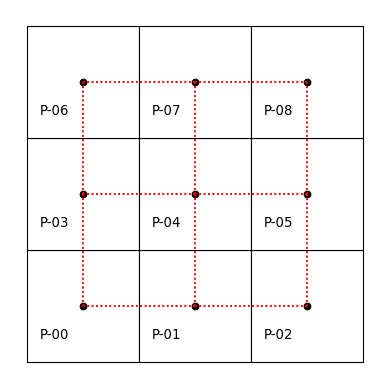

In [7]:
# Set up figure
f, ax = plt.subplots(1, 1, subplot_kw=dict(aspect="equal"))
# Plot grid
gdf.plot(facecolor="w", edgecolor="k", ax=ax)
# Loop over each cell and add the text
for x, y, t in zip(
    [p.centroid.x - 0.25 for p in polys],
    [p.centroid.y - 0.25 for p in polys],
    [i for i in gdf["id"]],
):
    plt.text(
        x,
        y,
        t,
        verticalalignment="center",
        horizontalalignment="center",
    )
# Plot weights connectivity
wr.plot(gdf, edge_kws=dict(color="r", linestyle=":"), ax=ax)
# Remove axes
ax.set_axis_off()

The  `neighbors` attribute of our `pysal` `W` object encodes the neighbor
relationships by expressing the *focal* observation on the left (in the `key` of the dictionary), and expressing the *neighbors* to the *focal* in the list on the right (in the `value` of the dictionary). This representation has computational advantages, as it exploits
the **sparse** nature of contiguity weights matrices by recording only non-zero weights:

In [8]:
wr.neighbors

{0: [1, 3],
 1: [0, 2, 4],
 2: [1, 5],
 3: [0, 4, 6],
 4: [1, 3, 5, 7],
 5: [8, 2, 4],
 6: [3, 7],
 7: [8, 4, 6],
 8: [5, 7]}

More specifically, knowing
that the neighbors of polygon $0$ are $3$ and $1$ implies that polygons $2, 4,
5, 6, 7, 8$ are not Rook neighbors of 0. As such, there is no reason to store
the "non-neighbor" information and this results in significant reductions in
memory requirements. However, it is possible to create the fully **dense**, matrix
representation if needed:

In [9]:
pd.DataFrame(*wr.full()).astype(int)

,0,1,2,3,4,5,6,7,8
0,0,1,0,1,0,0,0,0,0
1,1,0,1,0,1,0,0,0,0
2,0,1,0,0,0,1,0,0,0
3,1,0,0,0,1,0,1,0,0
4,0,1,0,1,0,1,0,1,0
5,0,0,1,0,1,0,0,0,1
6,0,0,0,1,0,0,0,1,0
7,0,0,0,0,1,0,1,0,1
8,0,0,0,0,0,1,0,1,0


As you can see from the matrix above, most entries are zero. In fact out of all of the possible $9^2=81$ linkages that there could be in this matrix, there are only twenty-four non-zero entries:

In [10]:
wr.nonzero

24

Thus, we can save a significant amount of memory and lose no information using these sparse representations, which only record the non-zero values. 

A close inspection reveals that this criterion actually places
a restriction on the spatial relation. More specifically, polygons $0$ and $4$
are not Rook neighbors, but they do in fact share a common border. However, in
this instance the sharing is due to a common *vertex* rather than a shared
*edge*. If we wanted them to be considered as neighbours, we can switch to the more inclusive notion of *Queen* contiguity, which
requires the pair of polygons to only share one or more *vertices*. We can create the
neighbor relations for this same configuration as follows:

In [11]:
# Build a queen contiguity matrix from a regular 3x3
# lattice stored in a geo-table
wq = weights.contiguity.Queen.from_dataframe(gdf)
wq.neighbors

{0: [1, 3, 4],
 1: [0, 2, 3, 4, 5],
 2: [1, 4, 5],
 3: [0, 1, 4, 6, 7],
 4: [0, 1, 2, 3, 5, 6, 7, 8],
 5: [1, 2, 4, 7, 8],
 6: [3, 4, 7],
 7: [3, 4, 5, 6, 8],
 8: [4, 5, 7]}

In addition to this neighbors representation, we can also express the graph visually, as done before. This is shown in the following figure.

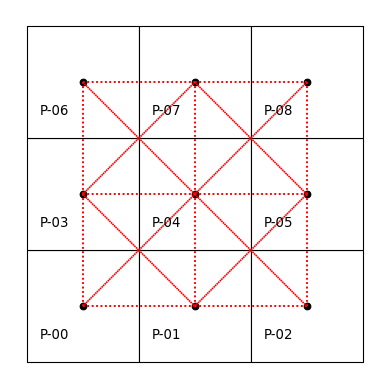

In [12]:
# Set up figure
f, ax = plt.subplots(1, 1, subplot_kw=dict(aspect="equal"))
# Plot grid
gdf.plot(facecolor="w", edgecolor="k", ax=ax)
# Loop over each cell and add the text
for x, y, t in zip(
    [p.centroid.x - 0.25 for p in polys],
    [p.centroid.y - 0.25 for p in polys],
    [i for i in gdf["id"]],
):
    plt.text(
        x,
        y,
        t,
        verticalalignment="center",
        horizontalalignment="center",
    )
# Plot weights connectivity
wq.plot(gdf, edge_kws=dict(color="r", linestyle=":"), ax=ax)
# Remove axes
ax.set_axis_off()

By using `Contiguity.Queen` rather than `Contiguity.Rook`, we consider observations that share a vertex to be neighbors. The result is that the neighbors of $0$ now include $4$ along with $3$ and $1$.

Akin to how the `neighbors` dictionary encodes the contiguity relations, the `weights` dictionary encodes the strength of the link connecting the focal to each neighbor. For contiguity
weights, observations are usually either considered "linked" or "not linked," so the resulting weights matrix is **binary**. As in any `pysal` `W` object, the actual weight values are contained in the `weights` attribute:

In [13]:
wq.weights

{0: [1.0, 1.0, 1.0],
 1: [1.0, 1.0, 1.0, 1.0, 1.0],
 2: [1.0, 1.0, 1.0],
 3: [1.0, 1.0, 1.0, 1.0, 1.0],
 4: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 5: [1.0, 1.0, 1.0, 1.0, 1.0],
 6: [1.0, 1.0, 1.0],
 7: [1.0, 1.0, 1.0, 1.0, 1.0],
 8: [1.0, 1.0, 1.0]}

Similar to the `neighbors` attribute, the `weights` object is a Python
dictionary that only stores the non-zero weights. Although the weights for a
given observations neighbors are all the same value for contiguity weights, it
is important to note that the `weights` and `neighbors` **are aligned with one another**; for each observation, its first neighbor in `neighbors` has the first weight in its `weights` entry. This will be important when we examine distance based weights further
on, when observations will have different weights. 

In addition to the `neighbor` and `weights` attributes, the `w` object has a
large number of other attributes and methods that can be useful. **The
`cardinalities` attribute reports the number of neighbors for each observation**:

In [14]:
wq.cardinalities

{0: 3, 1: 5, 2: 3, 3: 5, 4: 8, 5: 5, 6: 3, 7: 5, 8: 3}

Any ordered pair of contiguous observations constitutes a *join* represented by a non-zero weight in a $W$. In other words Polygons 0 and 1 are a join, and Polygons 1 and 0 are another join. The attribute `s0` records the number of joins (i.e. non-zero weights)

In [15]:
wq.s0

40.0

Thus, the Queen weights here have just under twice the number of joins in this case.
The `pct_nonzero` attribute provides a measure of the density (compliment of
sparsity) of the spatial weights matrix (if we had it stored explicitly, which
we don't):

In [16]:
wq.pct_nonzero

49.382716049382715

which is equal to $100 \times (\texttt{w.s0} / \texttt{w.n}^2)$.

### Spatial Weights from real-world geographic tables

The regular lattice map encountered above helps us to understand the logic and
properties of `pysal`'s spatial weights class. However, the artificial nature of
that geography is of limited relevance to real world research problems.
`pysal` supports the construction of spatial weights objects from a
number of commonly used spatial data formats. Here we demonstrate this
functionality for the case of census tracts in San Diego, California. Most spatial
data formats, such as shapefiles, are non-topological in that they encode the
polygons as a collection of vertices defining the edges of the geometry's
boundary. No information about the neighbor relations is explicitly encoded, so we
must construct it ourselves. Under the hood, `pysal` uses efficient spatial indexing
structures to extract these.


In [17]:
## Here we are going to read this tract data directly from a URL
san_diego_tracts = gpd.read_file(
    "https://www.dropbox.com/s/g8ete3zligcozzq/sandiego_tracts.gpkg?dl=1"
)


In [18]:
san_diego_tracts.head()

,GEOID,median_age,total_pop,total_pop_white,tt_work,hh_total,hh_female,total_bachelor,median_hh_income,income_gini,...,state,county,tract,area_sqm,pct_rented,pct_hh_female,pct_bachelor,pct_white,sub_30,geometry
0,06073018300,37.1,2590.0,2375.0,1299.0,2590.0,137.0,0.0,62500.0,0.5355,...,06,073,018300,2.876449,0.373913,0.052896,0.000000,0.916988,False,"POLYGON ((-13069450.120 3922380.770, -13069175..."
1,06073018601,41.2,5147.0,4069.0,1970.0,5147.0,562.0,24.0,88165.0,0.4265,...,06,073,018601,4.548797,0.205144,0.109190,0.004663,0.790558,False,"POLYGON ((-13067719.770 3922939.420, -13067631..."
2,06073017601,54.4,5595.0,4925.0,1702.0,5595.0,442.0,34.0,110804.0,0.4985,...,06,073,017601,8.726275,0.279029,0.078999,0.006077,0.880250,False,"POLYGON ((-13058166.110 3907247.690, -13058140..."
3,06073019301,42.3,7026.0,5625.0,3390.0,7026.0,638.0,46.0,100539.0,0.4003,...,06,073,019301,3.519743,0.196512,0.090806,0.006547,0.800598,False,"POLYGON ((-13056896.290 3925255.610, -13056868..."
4,06073018700,21.8,40402.0,30455.0,24143.0,40402.0,2456.0,23.0,41709.0,0.3196,...,06,073,018700,559.150793,0.949887,0.060789,0.000569,0.753799,False,"POLYGON ((-13090788.510 3946435.430, -13090736..."


In [19]:
w_queen = weights.contiguity.Queen.from_dataframe(san_diego_tracts)

Like before, we can visualize the adjacency relationships, but they are much more difficult to see without showing a closer detail. This higher level of detail is shown in the right pane of the plot.

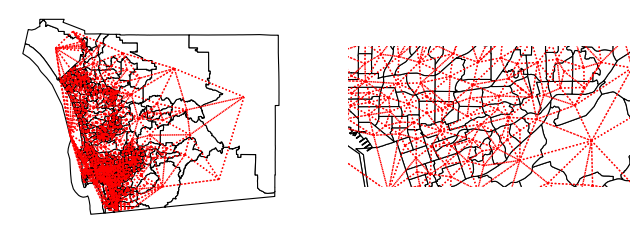

In [20]:
# Plot tract geography
f, axs = plt.subplots(1, 2, figsize=(8, 4))
for i in range(2):
    ax = san_diego_tracts.plot(
        edgecolor="k", facecolor="w", ax=axs[i]
    )
    # Plot graph connections
    w_queen.plot(
        san_diego_tracts,
        ax=axs[i],
        edge_kws=dict(color="r", linestyle=":", linewidth=1),
        node_kws=dict(marker=""),
    )
    # Remove the axis
    axs[i].set_axis_off()
axs[1].axis([-13040000, -13020000, 3850000, 3860000]);

The weights object for San Diego tracts have the same attributes and methods as
we encountered with our artificial layout above:

In [21]:
print(w_queen.n)
print(w_queen.pct_nonzero)

628
1.018296888311899


First we have a larger number of spatial units. The spatial weights are
also much sparser for the tracts than what we saw for our smaller toy
grid. Moreover, the cardinalities have a radically different distribution:

<Axes: ylabel='Frequency'>

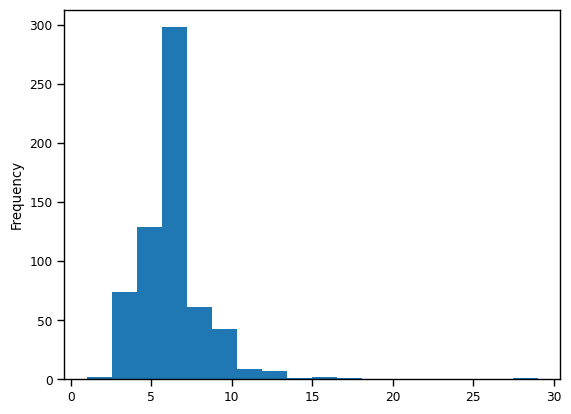

In [22]:
s = pd.Series(w_queen.cardinalities)
s.plot.hist(bins=s.unique().shape[0])

As the minimum number of neighbors is 1, while there is one polygon with 29
Queen neighbors. The most common number of neighbors is 6. For comparison, we
can also plot the equivalent for rook weights of the same dataframe:

0.8722463385938578


<Axes: ylabel='Frequency'>

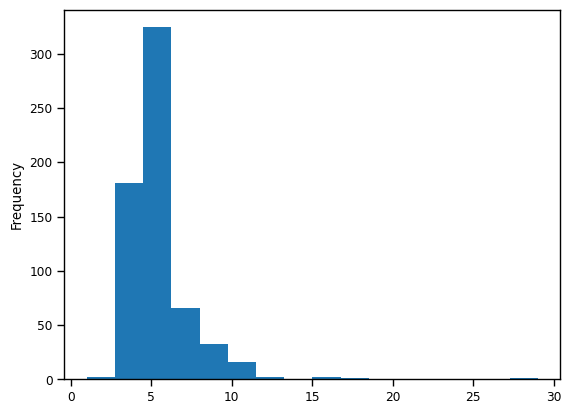

In [23]:
w_rook = weights.contiguity.Rook.from_dataframe(san_diego_tracts)
print(w_rook.pct_nonzero)
s = pd.Series(w_rook.cardinalities)
s.plot.hist(bins=s.unique().shape[0])

The cardinality histogram shifts downward due to the increasing sparsity of the
weights for the rook case relative to the Queen criterion. Conceptually, this makes sense: all Rook neighbors are also Queen neighbors, since Queen includes neighbors that share an edge; but, not all Queen neighbors are Rook neighbors, since some Queen neighbors only share a point on their boundaries in common. 

The example above shows how the notion of contiguity, although more
straightforward in the case of a grid, can be naturally extended beyond the
particular case of a regular lattice. The principle to keep in mind is that we
consider contiguous (and hence call neighbors) observations which share part
of their border coordinates. In the Queen case, a single point is enough to make
the join. For Rook neighbors, we require a join to consist of one or more
shared edges. This distinction is less relevant in the real world than
it appears in the grid example above. In any case, there are some cases
where this distinction can matter and it is useful to be familiar with the
differences between the two approaches. 

## Distance Based Weights

In addition to contiguity, we can also define neighbor relations as a function of
the distance separating spatial observations. Usually, this means that a matrix expressing the distances between all pairs of observations are required. These are then provided to a **kernel** function which uses the proximity information to model proximity as a smooth function of distance. `pysal` implements a family of
distance functions. Here we illustrate a selection beginning with the notion
of *nearest neighbor* weights.

### K-Nearest Neighbor weights

The first type of distance based weights defines the neighbor set of a
particular observation as containing its nearest $k$ observations, where the
user specifies the value of $k$. To illustrate this for the San Diego
tracts we take $k=4$. This still leaves the issue of how to measure the distance
between these polygon objects, however. To do so we develop a representative
point for each of the polygons using the centroid. 

In [24]:
wk4 = weights.distance.KNN.from_dataframe(san_diego_tracts, k=4)

The centroids are calculated from
the spatial information stored in the `GeoDataFrame` as we have seen before. Since we are dealing with
polygons in this case, `pysal` uses inter-centroid distances to determine the
$k$ nearest observations to each polygon. 

The k-nearest neighbor weights displays no island problem, that is *everyone* has at least one neighbor, since we have created a set of weights based on everyone having 4 (and only 4) neighbors!

In [25]:
wk4.islands

[]

In [26]:
wk4.weights[0]

[1.0, 1.0, 1.0, 1.0]

Everyone has the same number of neighbors. In some cases, this is not an issue but a desired feature. In
other contexts, however, this characteristic of k-nearest neighbor weights can be undesirable.
In such situations, we can turn to other types of distance-based weights.

### Kernel weights

The k-nearest neighbor rule assigns binary values to the weights for neighboring observations.
`pysal` also supports continuously valued weights to reflect Tobler's first law
{cite}`Tobler1970computer` in a more direct way: observations that are close to a unit have larger
weights than more distant observations.

Kernel weights are one of the most commonly-used kinds of distance weights. They
reflect the case where similarity/spatial proximity is assumed or expected to
decay with distance. The essence of kernel weights is that the weight between
observations $i$ and $j$ is based on their distance, but it is further modulated by
a kernel function with certain properties. `pysal` implements several kernels.
All of them share the properties of distance decay (thus encoding Tobler's First 
Law), but may decay at different rates with respect to distance.


</figure>
<img src="https://www.researchgate.net/publication/323460636/figure/fig4/AS:1086420894654636@1636034334990/Gaussian-kernel-function-used-in-the-GWR-model-Here-oi-is-weight-of-the-ith-observation.jpg" alt="drawing" width="600" style="display: block; margin: 0 auto"/>
<figcaption>From Zhan, C., Han, J., Hu, S., Liu, L., & Dong, Y. (2018). Spatial downscaling of GPM annual and monthly precipitation using regression-based algorithms in a mountainous area. Advances in Meteorology, 2018, 1-13.
</figcaption>
</figure>


Below are some examples of what might be ways to relate observations $i$ and $j$ is based on their distance:
</figure>
<img src="https://www.researchgate.net/publication/234704634/figure/fig1/AS:299724839112705@1448471378437/Conceptualizing-distance-decay-in-patient-physician-interactions-1a-gravity-function.png" alt="drawing" width="600" style="display: block; margin: 0 auto"/>
<figcaption>From Wang, F. (2012). Measurement, optimization, and impact of health care accessibility: a methodological review. Annals of the Association of American Geographers, 102(5), 1104-1112.
</figcaption>
</figure>


As a computational note, it is worth mentioning that many of these distance-based decay functions require more resources than the contiguity weights or K-nearest neighbor weights discussed above. This is because the contiguity & k-nearest neighbor structures embed simple assumptions about how shapes relate in space, while kernel functions relax several of those assumptions. Thus, they provide more flexibility at the expense of computation.

The simplest way to compute Kernel weights in `pysal` involves a single function
call:

In [27]:
w_kernel = weights.distance.Kernel.from_dataframe(gdf)

Like k-nearest neighbor weights, the Kernel weights are based on distances between observations. By default, if the input data is an areal unit, we use a central representative point (like the centroid) for that polygon.
The value of the weights will be a function of two main options for
kernel weights: choice of kernel function; and the bandwidth. The
former controls how distance between $i$ and $j$ is "modulated" to produce a
the weight that goes in $w_{ij}$. In this respect, `pysal` offers [a large number
of functions](https://pysal.org/libpysal/generated/libpysal.weights.Kernel.html) that determine the shape of the distance
decay function. The bandwidth specifies the distance from each focal unit over which
the kernel function is applied. **For observations separated by distances larger
than the bandwidth, the weights are set to zero.**

The default values for kernels are to use a triangular kernel with a bandwidth distance
equal to the maximum knn=2 distance
for all observations. The latter implies a so-called fixed bandwidth where all
observations use the same distance for the cut-off. We can inspect this from
the generated `W` object:

In [28]:
w_kernel.function

'triangular'

for the kernel function, and:

In [29]:
# Show the first five values of bandwidths
# and see they are all the same
w_kernel.bandwidth[0:5]

array([[1.0000001],
       [1.0000001],
       [1.0000001],
       [1.0000001],
       [1.0000001]])

For the bandwidth applied to each observation.

Although simple, a fixed bandwidth is not always the best choice. For example,
in cases where the density of the observations varies over the study region,
using the same threshold anywhere will result in regions with a high density
of neighbors while others with observations very sparsely connected. In these
situations, an *adaptive* bandwidth -one which varies by observation and its
characteristics- can be preferred. 

Adaptive bandwidths are picked again using a K-nearest neighbor rule. A bandwidth for each observation is chosen such that, once the $k$-nearest observation is considered, all the remaining observations have zero weight. To illustrate it, we will use a subset of tracts in our San Diego dataset. First, visualising the centroids, we can see that they are not exactly regularly-spaced, although others do nearly fall into a regular spacing:

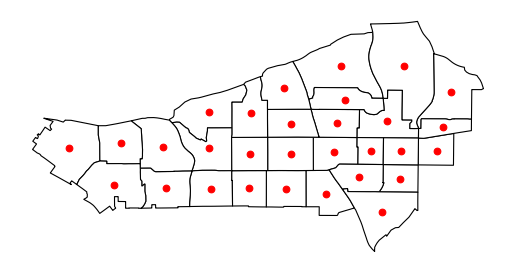

In [30]:
# Create subset of tracts
sub_30 = san_diego_tracts[san_diego_tracts['sub_30']==True]
# Plot polygons
ax = sub_30.plot(facecolor="w", edgecolor="k")
# Create and plot centroids
sub_30.head(30).centroid.plot(color="r", ax=ax)
# Remove axis
ax.set_axis_off()

First let's take a look at what fixed bandwith weights look like: 


In [31]:
w_fixed = weights.distance.Kernel.from_dataframe(sub_30)

Bandwidths are all the same: 

In [32]:
w_fixed.bandwidth[0:5]

array([[1563.47826787],
       [1563.47826787],
       [1563.47826787],
       [1563.47826787],
       [1563.47826787]])

And, we can visualize what these kernels look like on the map, too, by focusing on an individual unit and showing how the distance decay attenuates the weight by grabbing the corresponding row of the full kernel matrix:

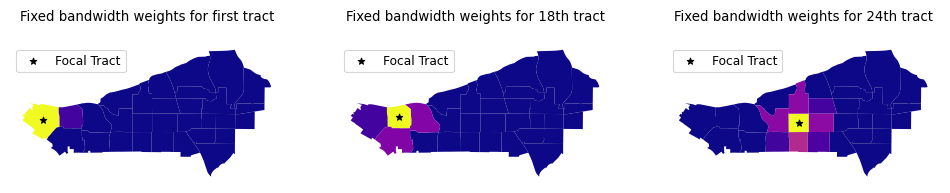

In [33]:
# Create full matrix version of weights
full_matrix, ids = w_fixed.full()
# Set up figure with two subplots in a row
f, ax = plt.subplots(
    1, 3, figsize=(12, 6), subplot_kw=dict(aspect="equal")
)
# Append weights for first polygon and plot on first subplot
sub_30.assign(weight_0=full_matrix[0]).plot(
    "weight_0", cmap="plasma", ax=ax[0]
)
# Append weights for 18th polygon and plot on first subplot
sub_30.assign(weight_18=full_matrix[17]).plot(
    "weight_18", cmap="plasma", ax=ax[1]
)

# Append weights for 24th polygon and plot on first subplot
sub_30.assign(weight_24=full_matrix[23]).plot(
    "weight_24", cmap="plasma", ax=ax[2]
)

# Add centroid of focal tracts
sub_30.iloc[[0], :].centroid.plot(
    ax=ax[0], marker="*", color="k", label="Focal Tract"
)
sub_30.iloc[[17], :].centroid.plot(
    ax=ax[1], marker="*", color="k", label="Focal Tract"
)
sub_30.iloc[[23], :].centroid.plot(
    ax=ax[2], marker="*", color="k", label="Focal Tract"
)
# Add titles
ax[0].set_title("Fixed bandwidth weights for first tract")
ax[1].set_title("Fixed bandwidth weights for 18th tract")
ax[2].set_title("Fixed bandwidth weights for 24th tract")

# Remove axis
[ax_.set_axis_off() for ax_ in ax]
# Add legend
[ax_.legend(loc="upper left") for ax_ in ax];

If we now build a weights object with adaptive bandwidth (`fixed=False`), the values for bandwith differ:

In [34]:
# Build weights with adaptive bandwidth and using the 15 nearest neighbors 
# to develop the bandwidth
w_adaptive = weights.distance.Kernel.from_dataframe(
    sub_30, fixed=False, k=15
)
# Print first five bandwidth values
w_adaptive.bandwidth[:5]

array([[7065.74020822],
       [3577.22591841],
       [2989.74807871],
       [2891.46196945],
       [3965.08354232]])

And, we can visualize what these kernels look like on the map, too, by focusing on an individual unit and showing how the distance decay attenuates the weight by grabbing the corresponding row of the full kernel matrix:

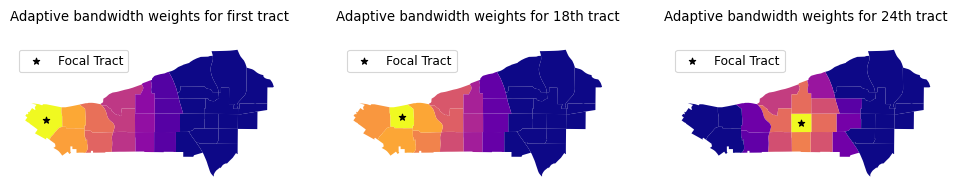

In [35]:
# Create full matrix version of weights
full_matrix, ids = w_adaptive.full()
# Set up figure with two subplots in a row
f, ax = plt.subplots(
    1, 3, figsize=(12, 6), subplot_kw=dict(aspect="equal")
)
# Append weights for first polygon and plot on first subplot
sub_30.assign(weight_0=full_matrix[0]).plot(
    "weight_0", cmap="plasma", ax=ax[0]
)
# Append weights for 18th polygon and plot on first subplot
sub_30.assign(weight_18=full_matrix[17]).plot(
    "weight_18", cmap="plasma", ax=ax[1]
)

# Append weights for 24th polygon and plot on first subplot
sub_30.assign(weight_24=full_matrix[23]).plot(
    "weight_24", cmap="plasma", ax=ax[2]
)

# Add centroid of focal tracts
sub_30.iloc[[0], :].centroid.plot(
    ax=ax[0], marker="*", color="k", label="Focal Tract"
)
sub_30.iloc[[17], :].centroid.plot(
    ax=ax[1], marker="*", color="k", label="Focal Tract"
)
sub_30.iloc[[23], :].centroid.plot(
    ax=ax[2], marker="*", color="k", label="Focal Tract"
)
# Add titles
ax[0].set_title("Adaptive bandwidth weights for first tract")
ax[1].set_title("Adaptive bandwidth weights for 18th tract")
ax[2].set_title("Adaptive bandwidth weights for 24th tract")

# Remove axis
[ax_.set_axis_off() for ax_ in ax]
# Add legend
[ax_.legend(loc="upper left") for ax_ in ax];

What the kernel looks like can be strongly affected by the structure of spatial proximity, so any part of the map can look quite different from any other part of the map. By imposing a clear distance decay over several of the neighbors of each observation,
kernel weights incorporate Tobler's law explicitly. Often, this comes at the cost of
increased memory requirements, as every single pair of observations within the
bandwidth distance is considered:

In [36]:
w_kernel.pct_nonzero

40.74074074074074

In many instances, this may be at odds with the nature of the spatial
interactions at hand, which operate over a more limited range of distance. In
these cases, expanding the neighborhood set beyond might lead us to consider
interactions which either do not take place, or are inconsequential. **Thus, for
both substantive and computational reasons, it might make sense to further
limit the range, keeping impacts to be hyper-local.**

### Distance bands and hybrid Weights

In some contexts, it makes sense to draw a circle around each observation and
consider as neighbors every other observation that falls within the circle.
In the GIS terminology, this is akin to drawing a buffer around each point and
performing a point-in-polygon operation that determines whether each of the
other observations are within the buffer. If they are, they are assigned a
weight of one in the spatial weights matrix, if not they receive a zero.

In [37]:
w_bdb = weights.distance.DistanceBand.from_dataframe(
    sub_30, 3000, binary=True
)

This creates a binary distance weights where every other observation within
a distance of 3000 meters is considered neighbor.

Distance band weights can also be continuously weighted. These could be seen as a kind of "censored" kernel, where the kernel function is applied only within a pre-specified distance. For example, let us calculate the DistanceBand weights that use inverse distance
weights up to a certain threshold and then truncate the weights to zero for
everyone else. For this example we will return to the small lattice example
covered in the beginning:

In [38]:
w_hy = weights.distance.DistanceBand.from_dataframe(
    sub_30, 3000, binary=False
)

We apply a threshold of 1.5 for this illustration. `pysal` truncates continuous
weights at this distance. It is important to keep in mind that the threshold
distance must use the same units of distance as the units used to define the
matrix.

To see the difference, consider a tract in our San Diego dataset.

The queen set of weights includes eight neighbors with a uniform weight of one:

In [39]:
wq_sd = weights.Queen.from_dataframe(sub_30)


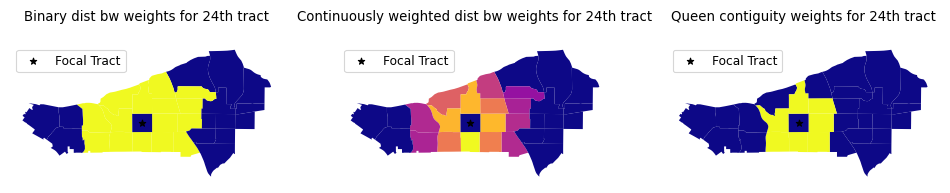

In [40]:
# Create full matrix version of weights
full_matrix1, ids1 = w_bdb.full()
full_matrix2, ids2 = w_hy.full()
full_matrix3, ids3 = wq_sd.full()

# Set up figure with two subplots in a row
f, ax = plt.subplots(
    1, 3, figsize=(12, 6), subplot_kw=dict(aspect="equal")
)
# Append weights for 24th polygon and plot on first subplot
sub_30.assign(weight_24=full_matrix1[23]).plot(
    "weight_24", cmap="plasma", ax=ax[0]
)

# Append weights for 24th polygon and plot on second subplot
sub_30.assign(weight_24=full_matrix2[23]).plot(
    "weight_24", cmap="plasma", ax=ax[1]
)

# Append weights for 24th polygon and plot on third subplot
sub_30.assign(weight_24=full_matrix3[23]).plot(
    "weight_24", cmap="plasma", ax=ax[2]
)

# Add centroid of focal tracts
sub_30.iloc[[23], :].centroid.plot(
    ax=ax[0], marker="*", color="k", label="Focal Tract"
)
sub_30.iloc[[23], :].centroid.plot(
    ax=ax[1], marker="*", color="k", label="Focal Tract"
)
sub_30.iloc[[23], :].centroid.plot(
    ax=ax[2], marker="*", color="k", label="Focal Tract"
)
# Add titles

ax[0].set_title("Binary dist bw weights for 24th tract")
ax[1].set_title("Continuously weighted dist bw weights for 24th tract")
ax[2].set_title("Queen contiguity weights for 24th tract")

# Remove axis
[ax_.set_axis_off() for ax_ in ax]
# Add legend
[ax_.legend(loc="upper left") for ax_ in ax];

## Block Weights 

A final type of spatial weight we examine here are block weights. In this case, 
it is membership in geographic
a group that defines the neighbor relationships. Block weights connect every
observation in a data set that belong to the same category in a provided list.
In essence, a block weight structure groups
individual observations and considers all members of the group as "near" one another. This means that they then have a value of one for every pair of observations in the same group. Contrariwise, all members *not* in that group are considered disconnected from any observation within the group, and given a value of zero. 
This is done for every group, so the resulting matrix looks like "blocks" of 1s stacked on the diagonal (assuming that observations in the same group are near one another in the input data table), hence the "block" weights. 

To demonstrate this class of spatial weights, we will use zones from the Mandatory Inclusionary Housing program in NYC,

In [41]:
mih = pd.read_json('https://data.cityofnewyork.us/resource/m79g-k9r4.json')
from shapely.geometry import shape

## the apply method applies the function to each row of the dataframe
mih['the_geom'] = mih['the_geom'].apply(shape)

## I'm going to use the GeoDataFrame method to create a GeoDataFrame
mih_geo = gpd.GeoDataFrame(mih,geometry='the_geom')

## Artificially create a unique ID for each row
mih_geo['id'] = np.arange(len(mih_geo)) 

In [42]:
mih_geo.shape

(202, 16)

In [43]:
mih_geo.head()

,the_geom,boro,status,project_nam,date_adopte,zr_ulurpno,zr_map,cd,mih_option,zoning_map,project_id,shape_leng,shape_le_1,shape_le_2,shape_area,id
0,"MULTIPOLYGON (((-73.97005 40.68022, -73.97017 ...",3,Adopted,587 Bergen Street Rezoning,2018-01-31T00:00:00.000,170357ZRK,CD8-Map 2 (Area 1),8,Option 1,16c,P2014K0056,994.864292,994.864292,994.864292,24194.095354,0
1,"MULTIPOLYGON (((-73.87734 40.84399, -73.87817 ...",2,Adopted,Lambert Houses Redevelopment Master Plan,2016-11-29T00:00:00.000,160288ZRX,CD6-Map 6 (Area 1),6,Option 1 and Deep Affordability Option,3d,P2013X0120,5871.253136,5871.253136,5871.253136,700002.648777,1
2,"MULTIPOLYGON (((-73.95934 40.65298, -73.95988 ...",3,Adopted,Caton Flats,2017-04-25T00:00:00.000,170129ZRK,CD14-Map 2 (Area 1),14,Option 2,16d,P2015K0157,881.625234,881.625234,881.625234,46239.338435,2
3,"MULTIPOLYGON (((-73.88122 40.84014, -73.88099 ...",2,Adopted,1932 Bryant Avenue,2016-11-29T00:00:00.000,160366ZRX,CD6-Map 7 (Area 2),6,Option 1 and Option 2,3d,P2014X0534,1568.622702,1568.622702,1568.622702,96628.576787,3
4,"MULTIPOLYGON (((-73.94532 40.79355, -73.94578 ...",1,Adopted,Lexington Gardens II,2016-11-29T00:00:00.000,160337ZRM,CD11-Map 1 (Area 1),11,Option 1,6b,P2014M0548,1549.849292,1549.849292,1549.849292,134693.552208,4


In [44]:

boros = pd.read_json('https://data.cityofnewyork.us/resource/7t3b-ywvw.json')

## the apply method applies the function to each row of the dataframe
boros['the_geom'] = boros['the_geom'].apply(shape)

## I'm going to use the GeoDataFrame method to create a GeoDataFrame
boros_geo = gpd.GeoDataFrame(boros,geometry='the_geom')


In [45]:
mih_geo[["id", "boro"]].head()

,id,boro
0,0,3
1,1,2
2,2,3
3,3,2
4,4,1


To build a block weights object, we do not even need spatial data beyond the
list of memberships. In this case, we will use the county membership:

In [46]:

w_bl = weights.util.block_weights(
    mih_geo["boro"].values,
    ids=mih_geo["id"].values,
)

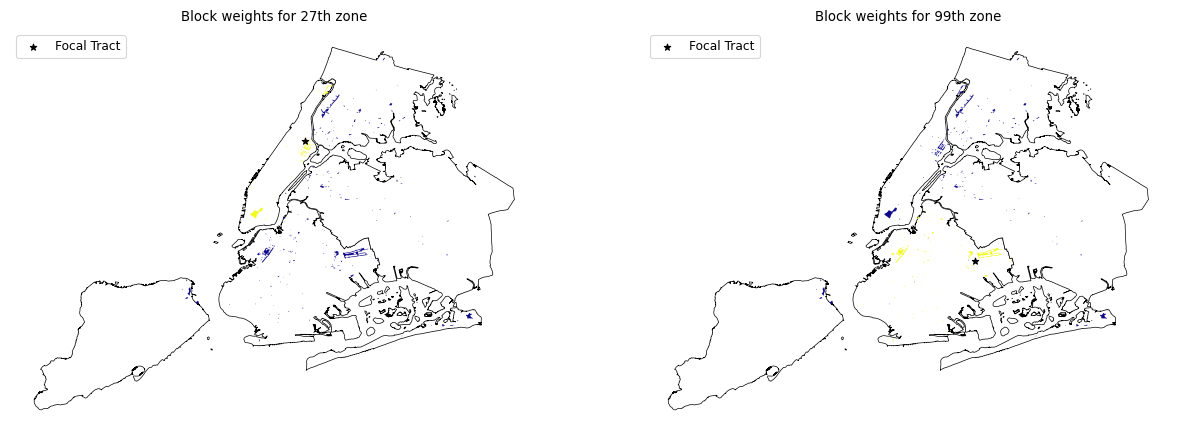

In [47]:
# Create full matrix version of weights
full_matrix, ids = w_bl.full()

# Set up figure with two subplots in a row
f, ax = plt.subplots(
    1, 2, figsize=(15, 6),
)

boros_geo.plot( ax=ax[0], color="white", edgecolor="black", linewidth=0.5)
boros_geo.plot( ax=ax[1], color="white", edgecolor="black", linewidth=0.5)

# Append weights for 24th polygon and plot on first subplot
mih_geo.assign(weight_28=full_matrix[28]).plot(
    "weight_28", cmap="plasma", ax=ax[0]
)

# Append weights for 24th polygon and plot on second subplot
mih_geo.assign(weight_100=full_matrix[100]).plot(
    "weight_100", cmap="plasma", ax=ax[1]
)

# Add centroid of focal tracts
mih_geo.iloc[[28], :].centroid.plot(
    ax=ax[0], marker="*", color="k", label="Focal Tract"
)
mih_geo.iloc[[100], :].centroid.plot(
    ax=ax[1], marker="*", color="k", label="Focal Tract"
)
# sub_30.iloc[[23], :].centroid.plot(
#     ax=ax[2], marker="*", color="k", label="Focal Tract"
# )
# Add titles

ax[0].set_title("Block weights for 27th zone")
ax[1].set_title("Block weights for 99th zone")
# ax[2].set_title("Queen contiguity weights for 24th tract")

# Remove axis
[ax_.set_axis_off() for ax_ in ax]
# Add legend
[ax_.legend(loc="upper left") for ax_ in ax];

## Conclusion

Spatial weights are central to how we *represent* spatial relationships in mathematical and computational environments. At their core, they are a "geo-graph," or a network defined by the geographical relationships between observations. They form kind of a "spatial index," in that they record which observations have a specific geographical relationship. Since spatial weights are fundamental to how spatial relationships are represented in geographic data science, we will use them again and again throughout the book. 

## Q.1 
While every node in a $k$-nearest neighbor graph has 5 neighbors, there is a conceptual difference between *in-degree* and *out-degree* of nodes in a graph. 

The *out-degree* of a node is the number of outgoing links from a node; for a K-Nearest Neighbor graph, this is $k$ for every variable. The *in-degree* of a node in a graph is the number of *incoming* links to that node; for a K-Nearest Neighbor graph, this is the number of other observations that pick the target as their nearest neighbor. The *in-degree* of a node in the K-Nearest Neighbor graph can provide a measure of *hubbiness*, or how central a node is to other nodes. 

1. Using the San Diego Tracts data, build a $k=6$ nearest neighbor weight and call it `knn_6`. 
2. Verify that the $k=6$ by taking the row sum over the weights matrix in `knn_6.sparse`.
3. Compute the in-degree of each observation by taking the *column sum* over the weights matrix in `knn_6.sparse`, and divide by 6, the out-degree for all observations. 
4. Make a histogram of the in-degrees for the $k=6$ weights. How evenly-distributed is the distribution of in-degrees?
5. Make a new histogram of the in-degree standardized by the out-degree when $k=26$. Does hubbiness reduce when increasing the number of $k$-nearest neighbors?


#### 1.

In [48]:
## Insert your code here

knn_6 = weights.distance.KNN.from_dataframe(san_diego_tracts, k=6)

#### 2.

In [54]:
## This will not show the matrix itself, but know that the output is 
## a numpy matrix.
row_sums = knn_6.sparse.sum(axis=1)

#verify that every row is equal to 6
(row_sums == 6).all()

True

We can sum along different dimensions of our matrix. 
- Axis = 1 allows us to sum each row
- Axis = 0 allows us to sum each column

#### 3. 

In [57]:
knn_6.sparse.shape

(628, 628)

In [80]:
## Insert your code here
knn_6_indeg = knn_6.sparse.sum(axis=0)

#standardize this by dividing it by 6
knn_6_indeg_standardized = knn_6_indeg/6

In [82]:
knn_6_indeg_flat = (knn_6_indeg).tolist()[0]

#### 4.

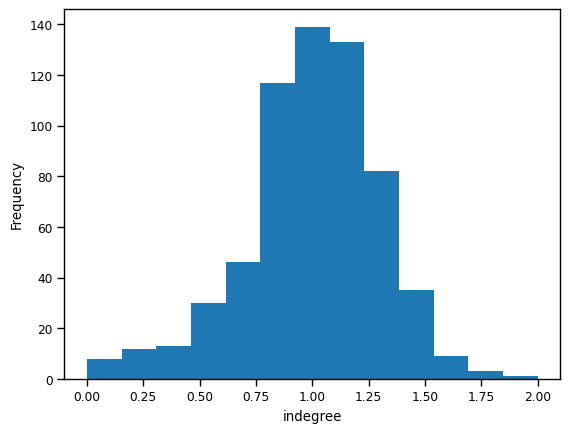

In [92]:
## Insert your code here

s = pd.Series(knn_6_indeg_flat)/6
ax = s.plot.hist(bins=s.unique().shape[0])
ax.set_xlabel("indegree")
plt.show()

#### 5.

In [84]:
## Insert your code here. 
knn_24 = weights.distance.KNN.from_dataframe(san_diego_tracts, k=24)

In [88]:
knn_24_indeg = knn_24.sparse.sum(axis=0)/24
knn_24_indeg_flat = (knn_24_indeg).tolist()[0]

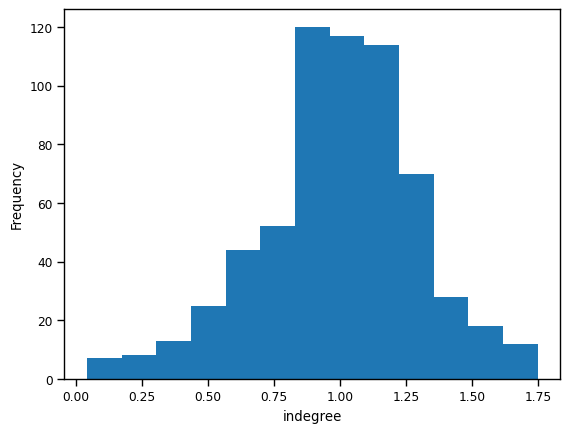

In [96]:
ax = (pd.Series(knn_24_indeg_flat)).plot.hist(bins=s.unique().shape[0])
ax.set_xlabel("indegree")
plt.show()